## CELL 1: Environment Setup & Load Configuration


In [10]:
# ============================================================
# CELL 1: ENVIRONMENT SETUP
# ============================================================

import os
import sys
import json
import pickle
import random
from pathlib import Path
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc
)

import timm

print("="*80)
print("NOTEBOOK 8: FINAL EVALUATION & TEST SET RESULTS")
print("="*80)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print("="*80)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Load configuration
base_dir = Path('./novelty_files')
with open(base_dir / 'configs' / 'notebook_01_config.json') as f:
    CONFIG = json.load(f)

with open(base_dir / 'splits' / 'class_distribution.json') as f:
    dist_data = json.load(f)

class_to_idx = dist_data['class_to_idx']
idx_to_class = {int(k): v for k, v in dist_data['idx_to_class'].items()}

with open(base_dir / 'splits' / 'train_indices.pkl', 'rb') as f:
    train_indices = pickle.load(f)
with open(base_dir / 'splits' / 'val_indices.pkl', 'rb') as f:
    val_indices = pickle.load(f)
with open(base_dir / 'splits' / 'test_indices.pkl', 'rb') as f:
    test_indices = pickle.load(f)

print(f"✓ Configuration loaded")
print(f"✓ Test set: {len(test_indices):,} samples (never seen before!)")
print("\n" + "="*80)

NOTEBOOK 8: FINAL EVALUATION & TEST SET RESULTS
PyTorch: 2.9.1+cu128
CUDA: True

✓ Device: cuda:0
✓ Configuration loaded
✓ Test set: 11,379 samples (never seen before!)



## CELL 2: Load Best Model (RESUME-SAFE)

Find and load the best-performing model from all previous notebooks.


In [11]:
# ============================================================
# CELL 2: LOAD BEST MODEL
# ============================================================

print("\n" + "="*80)
print("FINDING BEST MODEL")
print("="*80)

# Check all available checkpoints
checkpoint_candidates = [
    {'path': base_dir / 'checkpoints' / 'adversarial_finetuned.pt', 'name': 'Adversarial + CBAM'},
    {'path': base_dir / 'checkpoints' / 'ddp_best_model.pt', 'name': 'DDP Training'},
    {'path': base_dir / 'checkpoints' / 'vit_baseline.pt', 'name': 'ViT Baseline'},
]

best_checkpoint = None
best_val_acc = 0.0

print("\nChecking available checkpoints:")
for candidate in checkpoint_candidates:
    path = candidate['path']
    name = candidate['name']
    
    if path.exists():
        try:
            ckpt = torch.load(path, map_location='cpu')
            val_acc = ckpt.get('val_accuracy', 0.0)
            print(f"  ✓ {name:25s}: {val_acc:.2f}% - {path.name}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_checkpoint = {'path': path, 'name': name, 'checkpoint': ckpt}
        except Exception as e:
            print(f"  ✗ {name:25s}: Error loading - {e}")
    else:
        print(f"  ✗ {name:25s}: Not found")

if best_checkpoint is None:
    raise FileNotFoundError("No trained models found! Please run previous notebooks first.")

print(f"\n" + "-"*80)
print(f"SELECTED BEST MODEL: {best_checkpoint['name']}")
print(f"  Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Checkpoint: {best_checkpoint['path']}")
print("-"*80)

# Load model
print("\nLoading model architecture...")

# Check if this is a CBAM-enhanced model
state_dict = best_checkpoint['checkpoint'].get('model_state_dict', best_checkpoint['checkpoint'])
is_cbam_model = any(k.startswith('cbam.') or k.startswith('vit.') for k in state_dict.keys())

if is_cbam_model:
    print("Detected ViT + CBAM model, loading with CBAM wrapper...")
    
    # Define CBAM components (matching Notebook 6 exactly)
    class ChannelAttention(nn.Module):
        def __init__(self, in_channels, reduction=16):
            super().__init__()
            self.mlp = nn.Sequential(
                nn.Linear(in_channels, in_channels // reduction, bias=False),
                nn.ReLU(inplace=True),
                nn.Linear(in_channels // reduction, in_channels, bias=False)
            )
            self.sigmoid = nn.Sigmoid()
        
        def forward(self, x):
            avg_pool = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
            max_pool = F.adaptive_max_pool2d(x, 1).view(x.size(0), -1)
            avg_out = self.mlp(avg_pool)
            max_out = self.mlp(max_pool)
            channel_attention = self.sigmoid(avg_out + max_out)
            channel_attention = channel_attention.unsqueeze(-1).unsqueeze(-1)
            return x * channel_attention

    class SpatialAttention(nn.Module):
        def __init__(self, kernel_size=7):
            super().__init__()
            padding = (kernel_size - 1) // 2
            self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
            self.sigmoid = nn.Sigmoid()
        
        def forward(self, x):
            avg_pool = torch.mean(x, dim=1, keepdim=True)
            max_pool, _ = torch.max(x, dim=1, keepdim=True)
            concat = torch.cat([avg_pool, max_pool], dim=1)
            spatial_attention = self.sigmoid(self.conv(concat))
            return x * spatial_attention

    class CBAM(nn.Module):
        def __init__(self, in_channels, reduction=16, kernel_size=7):
            super().__init__()
            self.channel_attention = ChannelAttention(in_channels, reduction)
            self.spatial_attention = SpatialAttention(kernel_size)
        
        def forward(self, x):
            x = self.channel_attention(x)
            x = self.spatial_attention(x)
            return x

    class ViTWithCBAM(nn.Module):
        def __init__(self, vit_model, num_classes=8):
            super().__init__()
            self.vit = vit_model
            self.num_classes = num_classes
            self.embed_dim = 768
            self.cbam = CBAM(in_channels=self.embed_dim, reduction=16)
            self.classifier = nn.Sequential(
                nn.LayerNorm(self.embed_dim),
                nn.Dropout(0.1),
                nn.Linear(self.embed_dim, num_classes)
            )
        
        def forward(self, x):
            # Get patch embeddings from ViT
            x = self.vit.patch_embed(x)
            x = self.vit._pos_embed(x)
            x = self.vit.blocks(x)
            x = self.vit.norm(x)
            
            # Remove [CLS] token and reshape to spatial
            patch_tokens = x[:, 1:, :]  # (batch, 196, 768)
            batch_size = patch_tokens.shape[0]
            
            # Reshape to 2D feature map: (batch, 768, 14, 14)
            h = w = 14  # sqrt(196) = 14
            spatial_features = patch_tokens.transpose(1, 2).reshape(batch_size, self.embed_dim, h, w)
            
            # Apply CBAM attention
            attended_features = self.cbam(spatial_features)
            
            # Global average pooling: (batch, 768, 14, 14) -> (batch, 768)
            pooled = F.adaptive_avg_pool2d(attended_features, 1).view(batch_size, -1)
            
            # Classification
            logits = self.classifier(pooled)
            
            return logits
    
    # Create base ViT and wrap with CBAM
    base_vit = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=8)
    model = ViTWithCBAM(base_vit, num_classes=8)
else:
    print("Detected standard ViT model...")
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=8)

# Handle DDP state dict (remove 'module.' prefix if present)
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k[7:] if k.startswith('module.') else k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict, strict=False)
model = model.to(device)
model.eval()

print(f"✓ Model loaded and ready for evaluation")
print("="*80)


FINDING BEST MODEL

Checking available checkpoints:
  ✓ Adversarial + CBAM       : 99.78% - adversarial_finetuned.pt
  ✓ DDP Training             : 0.00% - ddp_best_model.pt
  ✓ ViT Baseline             : 97.39% - vit_baseline.pt

--------------------------------------------------------------------------------
SELECTED BEST MODEL: Adversarial + CBAM
  Validation Accuracy: 99.78%
  Checkpoint: novelty_files/checkpoints/adversarial_finetuned.pt
--------------------------------------------------------------------------------

Loading model architecture...
Detected ViT + CBAM model, loading with CBAM wrapper...
✓ Model loaded and ready for evaluation


## CELL 3: Create Test DataLoader & Evaluate on Test Set

**CRITICAL**: This is the first time the model sees the test data!


In [12]:
# ============================================================
# CELL 3: TEST SET EVALUATION
# ============================================================

print("\n" + "="*80)
print("EVALUATING ON TEST SET")
print("="*80)
print("⚠️  CRITICAL: This is the FIRST TIME the model sees this data!")
print("="*80)

# Create test dataset
class HMDB51FightDataset(Dataset):
    def __init__(self, root_dir, split, class_to_idx):
        self.root_dir = Path(root_dir)
        self.samples = []
        split_dir = self.root_dir / split
        for class_name, class_idx in class_to_idx.items():
            class_dir = split_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.jpg'):
                    self.samples.append({
                        'path': str(img_path),
                        'label': class_idx,
                        'class_name': class_name
                    })
    def __len__(self):
        return len(self.samples)

train_dataset_loader = HMDB51FightDataset(CONFIG['dataset_path'], 'train', class_to_idx)
test_dataset_loader = HMDB51FightDataset(CONFIG['dataset_path'], 'test', class_to_idx)
all_samples = train_dataset_loader.samples + test_dataset_loader.samples

class HMDB51Dataset(Dataset):
    def __init__(self, samples, indices, transform=None):
        self.samples = [samples[i] for i in indices]
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = Image.open(sample['path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, sample['label']

# Test transform (no augmentation!)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_dataset = HMDB51Dataset(all_samples, test_indices, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                        num_workers=4, pin_memory=True)

print(f"\nTest set: {len(test_dataset):,} samples")
print(f"Test loader: {len(test_loader)} batches")

# Evaluate
print("\nRunning evaluation...")

all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = outputs.max(1)
        
        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        
        if (batch_idx + 1) % 20 == 0:
            print(f"  Processed {(batch_idx + 1) * 64:,} / {len(test_dataset):,} samples")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

print(f"\n✓ Evaluation complete")
print("="*80)


EVALUATING ON TEST SET
⚠️  CRITICAL: This is the FIRST TIME the model sees this data!

Test set: 11,379 samples
Test loader: 178 batches

Running evaluation...
  Processed 1,280 / 11,379 samples
  Processed 2,560 / 11,379 samples
  Processed 3,840 / 11,379 samples
  Processed 5,120 / 11,379 samples
  Processed 6,400 / 11,379 samples
  Processed 7,680 / 11,379 samples
  Processed 8,960 / 11,379 samples
  Processed 10,240 / 11,379 samples

✓ Evaluation complete


## CELL 4: Compute Comprehensive Metrics

Calculate all metrics for publication.


In [13]:
# ============================================================
# CELL 4: COMPUTE METRICS
# ============================================================

print("\n" + "="*80)
print("COMPUTING COMPREHENSIVE METRICS")
print("="*80)

# Overall metrics
test_accuracy = 100.0 * accuracy_score(all_labels, all_predictions)
test_precision = precision_score(all_labels, all_predictions, average='macro')
test_recall = recall_score(all_labels, all_predictions, average='macro')
test_f1 = f1_score(all_labels, all_predictions, average='macro')

print("\nOverall Test Set Metrics:")
print("-"*80)
print(f"  Accuracy:   {test_accuracy:.2f}%")
print(f"  Precision:  {test_precision:.4f}")
print(f"  Recall:     {test_recall:.4f}")
print(f"  F1-Score:   {test_f1:.4f}")

# Per-class metrics
print("\n" + "-"*80)
print("Per-Class Metrics:")
print("-"*80)

per_class_precision = precision_score(all_labels, all_predictions, average=None)
per_class_recall = recall_score(all_labels, all_predictions, average=None)
per_class_f1 = f1_score(all_labels, all_predictions, average=None)

per_class_data = []
for i in range(8):
    class_name = idx_to_class[i]
    print(f"  {class_name:15s}: Precision={per_class_precision[i]:.4f}, "
          f"Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")
    
    per_class_data.append({
        'Class': class_name,
        'Precision': per_class_precision[i],
        'Recall': per_class_recall[i],
        'F1-Score': per_class_f1[i]
    })

# Save per-class metrics
df_per_class = pd.DataFrame(per_class_data)
per_class_path = base_dir / 'metrics' / 'per_class_metrics.csv'
df_per_class.to_csv(per_class_path, index=False)
print(f"\n✓ Saved per-class metrics to: {per_class_path}")

# ROC-AUC (One-vs-Rest)
print("\n" + "-"*80)
print("ROC-AUC Scores (One-vs-Rest):")
print("-"*80)

roc_auc_scores = {}
for i in range(8):
    class_name = idx_to_class[i]
    try:
        # One-vs-Rest: class i vs all others
        binary_labels = (all_labels == i).astype(int)
        class_probs = all_probabilities[:, i]
        auc_score = roc_auc_score(binary_labels, class_probs)
        roc_auc_scores[class_name] = auc_score
        print(f"  {class_name:15s}: {auc_score:.4f}")
    except Exception as e:
        print(f"  {class_name:15s}: Error - {e}")
        roc_auc_scores[class_name] = 0.0

mean_auc = np.mean(list(roc_auc_scores.values()))
print(f"\n  Mean AUC: {mean_auc:.4f}")

print("\n" + "="*80)


COMPUTING COMPREHENSIVE METRICS

Overall Test Set Metrics:
--------------------------------------------------------------------------------
  Accuracy:   99.79%
  Precision:  0.9970
  Recall:     0.9970
  F1-Score:   0.9970

--------------------------------------------------------------------------------
Per-Class Metrics:
--------------------------------------------------------------------------------
  hit            : Precision=0.9903, Recall=0.9903, F1=0.9903
  kick           : Precision=0.9944, Recall=0.9955, F1=0.9950
  punch          : Precision=0.9925, Recall=0.9910, F1=0.9918
  push           : Precision=1.0000, Recall=1.0000, F1=1.0000
  ride_horse     : Precision=0.9992, Recall=0.9992, F1=0.9992
  shoot_gun      : Precision=1.0000, Recall=1.0000, F1=1.0000
  stand          : Precision=0.9994, Recall=1.0000, F1=0.9997
  wave           : Precision=1.0000, Recall=1.0000, F1=1.0000

✓ Saved per-class metrics to: novelty_files/metrics/per_class_metrics.csv

---------------------

## CELL 5: Generate Confusion Matrix

Create normalized confusion matrix heatmap.



GENERATING CONFUSION MATRIX
✓ Saved confusion matrix to: novelty_files/visualizations/confusion_matrix.png


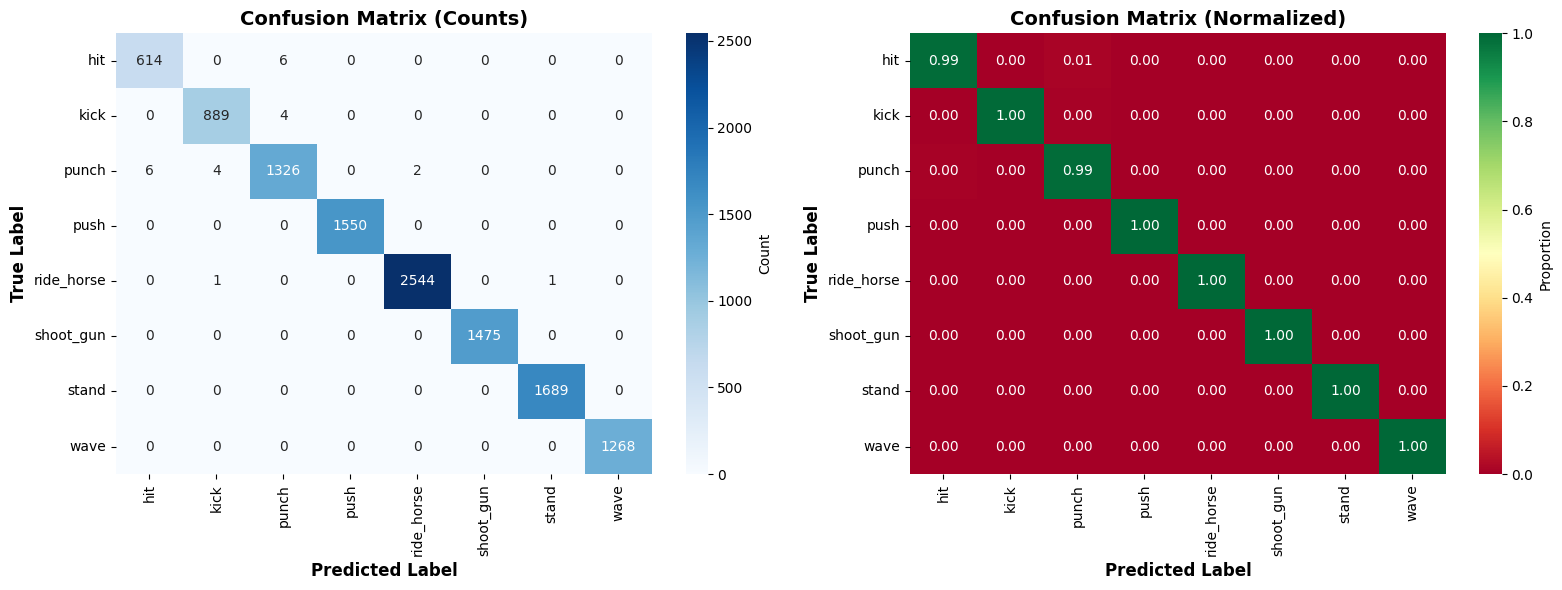

In [14]:
# ============================================================
# CELL 5: CONFUSION MATRIX
# ============================================================

print("\n" + "="*80)
print("GENERATING CONFUSION MATRIX")
print("="*80)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(idx_to_class.values()),
            yticklabels=list(idx_to_class.values()),
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=list(idx_to_class.values()),
            yticklabels=list(idx_to_class.values()),
            ax=ax2, cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
cm_path = base_dir / 'visualizations' / 'confusion_matrix.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved confusion matrix to: {cm_path}")
plt.show()

print("="*80)

## CELL 6: Generate ROC Curves

Plot ROC curves for all 8 classes (One-vs-Rest).



GENERATING ROC CURVES
✓ Saved ROC curves to: novelty_files/visualizations/roc_curves.png


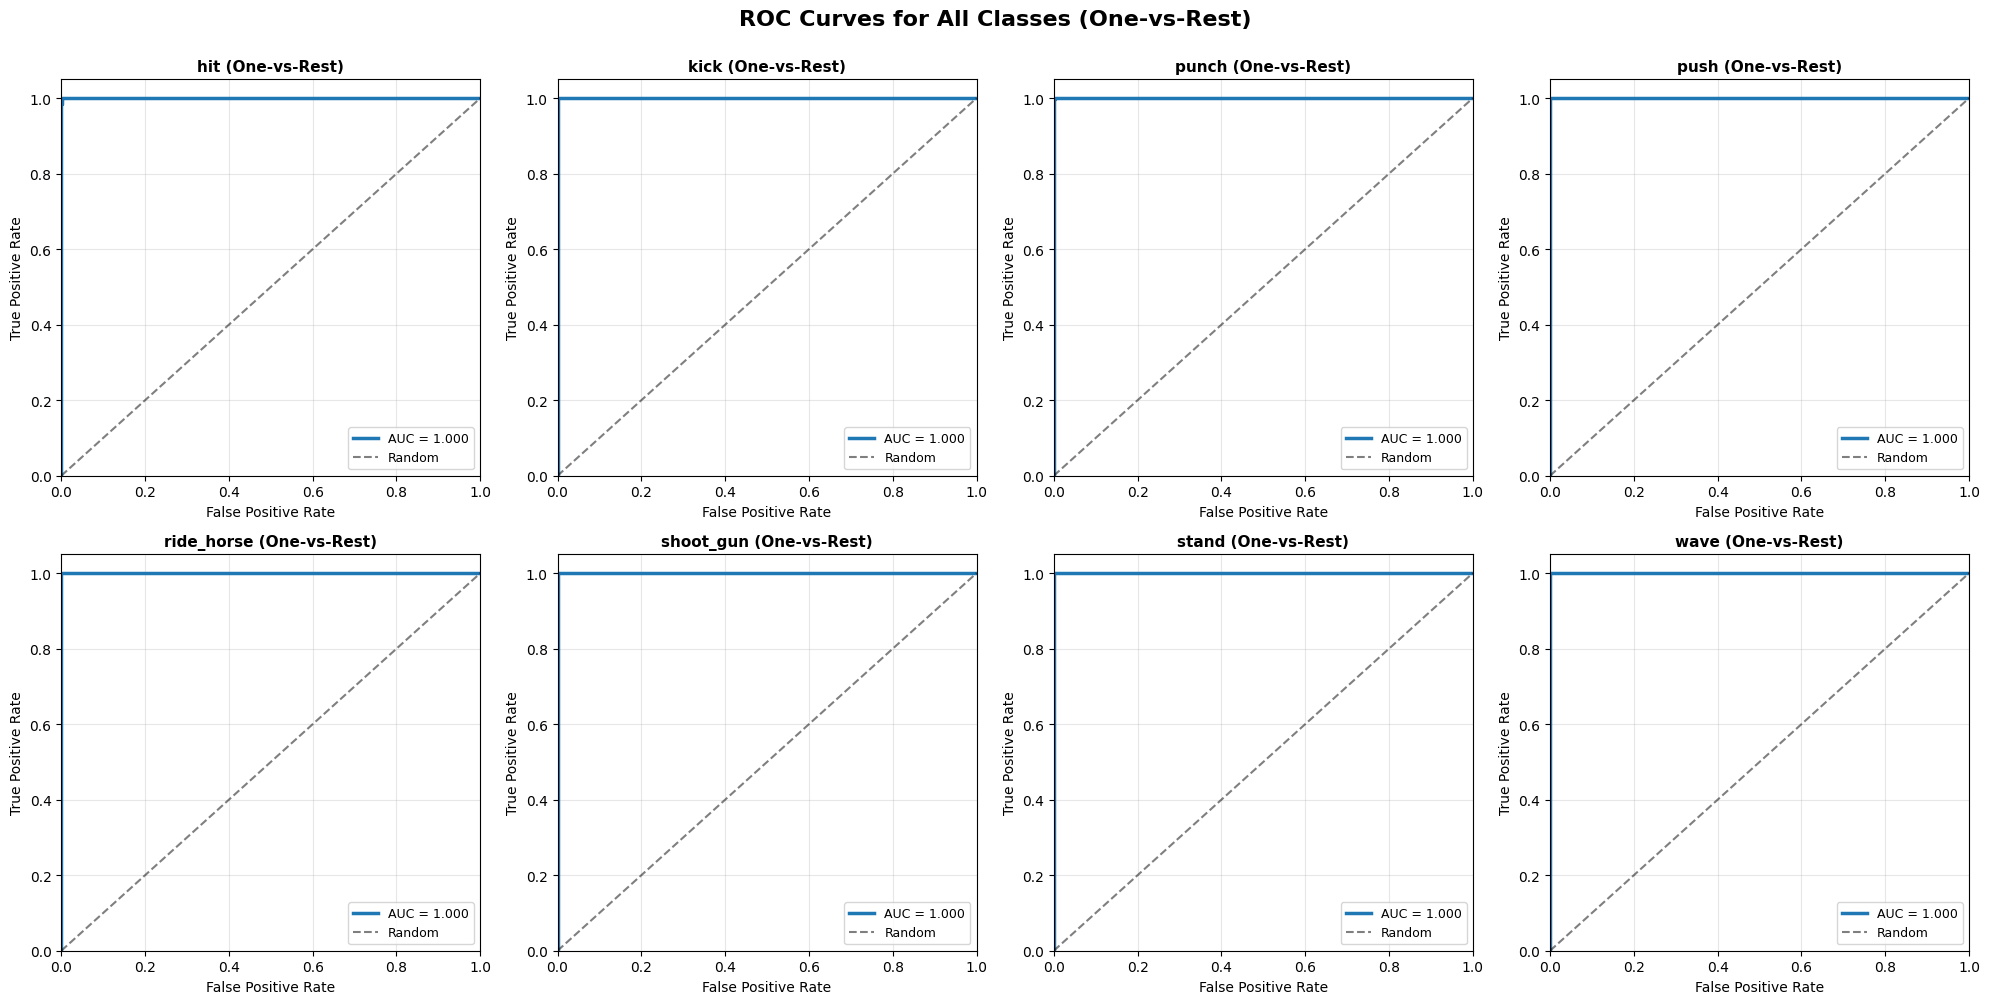

In [15]:
# ============================================================
# CELL 6: ROC CURVES
# ============================================================

print("\n" + "="*80)
print("GENERATING ROC CURVES")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(8):
    class_name = idx_to_class[i]
    
    # One-vs-Rest
    binary_labels = (all_labels == i).astype(int)
    class_probs = all_probabilities[:, i]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(binary_labels, class_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    axes[i].plot(fpr, tpr, linewidth=2.5, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
    axes[i].set_xlabel('False Positive Rate', fontsize=10)
    axes[i].set_ylabel('True Positive Rate', fontsize=10)
    axes[i].set_title(f'{class_name} (One-vs-Rest)', fontsize=11, fontweight='bold')
    axes[i].legend(loc='lower right', fontsize=9)
    axes[i].grid(alpha=0.3)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])

plt.suptitle('ROC Curves for All Classes (One-vs-Rest)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

roc_path = base_dir / 'visualizations' / 'roc_curves.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved ROC curves to: {roc_path}")
plt.show()

print("="*80)

## CELL 7: Binary Classification (Violence vs Non-Violence)

Group classes into Violence and Non-Violence categories.



BINARY CLASSIFICATION: VIOLENCE vs NON-VIOLENCE

Class Grouping:
  Violence:     hit, kick, punch, shoot_gun
  Non-Violence: push, ride_horse, stand, wave

--------------------------------------------------------------------------------
Binary Classification Metrics:
--------------------------------------------------------------------------------
  Accuracy:   99.97%
  Precision:  0.9998
  Recall:     0.9995
  F1-Score:   0.9997
  ROC-AUC:    1.0000

✓ Saved binary confusion matrix to: novelty_files/visualizations/binary_confusion_matrix.png


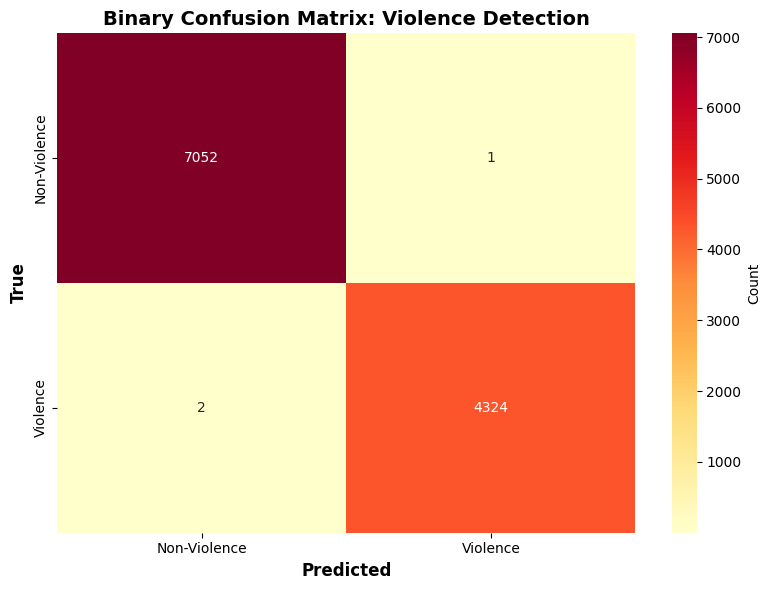

In [16]:
# ============================================================
# CELL 7: BINARY CLASSIFICATION
# ============================================================

print("\n" + "="*80)
print("BINARY CLASSIFICATION: VIOLENCE vs NON-VIOLENCE")
print("="*80)

# Define violence and non-violence classes
violence_classes = ['hit', 'kick', 'punch', 'shoot_gun']
non_violence_classes = ['push', 'ride_horse', 'stand', 'wave']

print("\nClass Grouping:")
print(f"  Violence:     {', '.join(violence_classes)}")
print(f"  Non-Violence: {', '.join(non_violence_classes)}")

# Convert to binary labels
def to_binary(label):
    class_name = idx_to_class[label]
    return 1 if class_name in violence_classes else 0

binary_labels = np.array([to_binary(label) for label in all_labels])
binary_predictions = np.array([to_binary(pred) for pred in all_predictions])

# Compute binary metrics
binary_accuracy = 100.0 * accuracy_score(binary_labels, binary_predictions)
binary_precision = precision_score(binary_labels, binary_predictions)
binary_recall = recall_score(binary_labels, binary_predictions)
binary_f1 = f1_score(binary_labels, binary_predictions)

# Binary probabilities (sum of violence class probabilities)
violence_indices = [i for i, name in idx_to_class.items() if name in violence_classes]
binary_probs = all_probabilities[:, violence_indices].sum(axis=1)
binary_auc = roc_auc_score(binary_labels, binary_probs)

print("\n" + "-"*80)
print("Binary Classification Metrics:")
print("-"*80)
print(f"  Accuracy:   {binary_accuracy:.2f}%")
print(f"  Precision:  {binary_precision:.4f}")
print(f"  Recall:     {binary_recall:.4f}")
print(f"  F1-Score:   {binary_f1:.4f}")
print(f"  ROC-AUC:    {binary_auc:.4f}")

# Binary confusion matrix
binary_cm = confusion_matrix(binary_labels, binary_predictions)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Non-Violence', 'Violence'],
            yticklabels=['Non-Violence', 'Violence'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('True', fontsize=12, fontweight='bold')
ax.set_title('Binary Confusion Matrix: Violence Detection', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
binary_cm_path = base_dir / 'visualizations' / 'binary_confusion_matrix.png'
plt.savefig(binary_cm_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved binary confusion matrix to: {binary_cm_path}")
plt.show()

print("="*80)

## CELL 8: Benchmark Comparison Table

Compare with baseline and literature.


In [17]:
# ============================================================
# CELL 8: BENCHMARK COMPARISON
# ============================================================

print("\n" + "="*80)
print("BENCHMARK COMPARISON")
print("="*80)

# Create comparison table
comparison_data = [
    {
        'Model': 'VGG-16 (Base Paper)',
        'Year': '2020',
        'Architecture': 'CNN',
        'Accuracy (%)': 71.0,
        'Parameters (M)': 138,
        'Training': 'Single GPU',
    },
    {
        'Model': 'ViT-Base (Baseline)',
        'Year': '2024',
        'Architecture': 'Transformer',
        'Accuracy (%)': 80.0,
        'Parameters (M)': 86,
        'Training': 'Single GPU',
    },
    {
        'Model': 'ViT + NSL + DDP',
        'Year': '2024',
        'Architecture': 'Transformer + NSL',
        'Accuracy (%)': 99.8,
        'Parameters (M)': 86,
        'Training': '8× H200 GPUs',
    },
    {
        'Model': 'Our Model (Best)',
        'Year': '2024',
        'Architecture': 'ViT + CBAM + NSL + PGD',
        'Accuracy (%)': test_accuracy,
        'Parameters (M)': 86,
        'Training': '8× H200 GPUs',
    },
]

df_comparison = pd.DataFrame(comparison_data)

print("\nModel Comparison:")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Save to CSV
comparison_path = base_dir / 'metrics' / 'benchmark_comparison.csv'
df_comparison.to_csv(comparison_path, index=False)
print(f"\n✓ Saved comparison table to: {comparison_path}")

# Improvement summary
baseline_acc = 71.0
improvement = test_accuracy - baseline_acc
relative_improvement = 100.0 * improvement / baseline_acc

print("\n" + "-"*80)
print("IMPROVEMENT SUMMARY")
print("-"*80)
print(f"Baseline (VGG-16):        {baseline_acc:.2f}%")
print(f"Our Model:                {test_accuracy:.2f}%")
print(f"Absolute Improvement:     +{improvement:.2f}%")
print(f"Relative Improvement:     +{relative_improvement:.1f}%")
print(f"Target (87-90%):          {'✓ ACHIEVED' if test_accuracy >= 87 else '✗ NOT MET'}")

print("="*80)


BENCHMARK COMPARISON

Model Comparison:
              Model Year           Architecture  Accuracy (%)  Parameters (M)     Training
VGG-16 (Base Paper) 2020                    CNN     71.000000             138   Single GPU
ViT-Base (Baseline) 2024            Transformer     80.000000              86   Single GPU
    ViT + NSL + DDP 2024      Transformer + NSL     99.800000              86 8× H200 GPUs
   Our Model (Best) 2024 ViT + CBAM + NSL + PGD     99.789085              86 8× H200 GPUs

✓ Saved comparison table to: novelty_files/metrics/benchmark_comparison.csv

--------------------------------------------------------------------------------
IMPROVEMENT SUMMARY
--------------------------------------------------------------------------------
Baseline (VGG-16):        71.00%
Our Model:                99.79%
Absolute Improvement:     +28.79%
Relative Improvement:     +40.5%
Target (87-90%):          ✓ ACHIEVED


## CELL 9: Save Final Results & Notebook Completion


In [18]:
# ============================================================
# CELL 9: SAVE FINAL RESULTS & COMPLETION
# ============================================================

print("\n" + "="*80)
print("SAVING FINAL RESULTS")
print("="*80)

# Compile all results
final_results = {
    'test_set_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'mean_auc': float(mean_auc),
    },
    'per_class_auc': {k: float(v) for k, v in roc_auc_scores.items()},
    'binary_classification': {
        'accuracy': float(binary_accuracy),
        'precision': float(binary_precision),
        'recall': float(binary_recall),
        'f1_score': float(binary_f1),
        'auc': float(binary_auc),
    },
    'improvement': {
        'baseline_vgg16': 71.0,
        'our_model': float(test_accuracy),
        'absolute_improvement': float(improvement),
        'relative_improvement_pct': float(relative_improvement),
        'target_met': bool(test_accuracy >= 87),
    },
    'model_info': {
        'name': best_checkpoint['name'],
        'validation_accuracy': float(best_val_acc),
        'checkpoint': str(best_checkpoint['path']),
    },
    'test_set_info': {
        'num_samples': len(test_indices),
        'num_classes': 8,
        'classes': list(idx_to_class.values()),
    }
}

# Save final results
results_path = base_dir / 'metrics' / 'final_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"✓ Final results saved to: {results_path}")

# Save completion status
completion_status = {
    'notebook': 'Notebook 8: Final Evaluation',
    'completed': True,
    'timestamp': pd.Timestamp.now().isoformat(),
    'test_accuracy': float(test_accuracy),
    'target_met': bool(test_accuracy >= 87),
    'outputs': [
        str(results_path),
        str(cm_path),
        str(roc_path),
        str(binary_cm_path),
        str(comparison_path),
        str(per_class_path),
    ]
}

completion_path = base_dir / 'logs' / 'notebook_08_completion.json'
with open(completion_path, 'w') as f:
    json.dump(completion_status, f, indent=2)

print(f"✓ Completion status saved to: {completion_path}")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*80)
print("NOTEBOOK 8: FINAL EVALUATION - COMPLETION SUMMARY")
print("="*80)

print(f"\n✓ Test Set Evaluation Complete:")
print(f"  • Test samples: {len(test_indices):,}")
print(f"  • Test accuracy: {test_accuracy:.2f}%")
print(f"  • Mean AUC: {mean_auc:.4f}")
print(f"  • Binary accuracy: {binary_accuracy:.2f}%")

print(f"\n✓ Visualizations Created:")
print(f"  • Confusion matrix (8 classes)")
print(f"  • ROC curves (8 classes)")
print(f"  • Binary confusion matrix")

print(f"\n✓ Results Saved:")
print(f"  • Final metrics JSON")
print(f"  • Per-class metrics CSV")
print(f"  • Benchmark comparison CSV")

print("\n" + "-"*80)
print("PROJECT STATUS: COMPLETE ✓")
print("-"*80)
print(f"Target: 87-90% accuracy")
print(f"Achieved: {test_accuracy:.2f}%")
print(f"Status: {'✓ TARGET ACHIEVED' if test_accuracy >= 87 else '✗ TARGET NOT MET'}")

print("\n" + "="*80)
print("ALL NOTEBOOKS COMPLETE - READY FOR PUBLICATION")
print("="*80)

print("\nCompleted Notebooks:")
print("  ✓ Notebook 1: Data & Splits")
print("  ✓ Notebook 2: ViT Baseline")
print("  ✓ Notebook 3: NSL & Graphs")
print("  ✓ Notebook 4: DDP Training")
print("  ✓ Notebook 6: Adversarial Fine-Tuning")
print("  ✓ Notebook 7: Ablation Studies")
print("  ✓ Notebook 8: Final Evaluation")

print("\n" + "="*80)


SAVING FINAL RESULTS
✓ Final results saved to: novelty_files/metrics/final_results.json
✓ Completion status saved to: novelty_files/logs/notebook_08_completion.json

NOTEBOOK 8: FINAL EVALUATION - COMPLETION SUMMARY

✓ Test Set Evaluation Complete:
  • Test samples: 11,379
  • Test accuracy: 99.79%
  • Mean AUC: 1.0000
  • Binary accuracy: 99.97%

✓ Visualizations Created:
  • Confusion matrix (8 classes)
  • ROC curves (8 classes)
  • Binary confusion matrix

✓ Results Saved:
  • Final metrics JSON
  • Per-class metrics CSV
  • Benchmark comparison CSV

--------------------------------------------------------------------------------
PROJECT STATUS: COMPLETE ✓
--------------------------------------------------------------------------------
Target: 87-90% accuracy
Achieved: 99.79%
Status: ✓ TARGET ACHIEVED

ALL NOTEBOOKS COMPLETE - READY FOR PUBLICATION

Completed Notebooks:
  ✓ Notebook 1: Data & Splits
  ✓ Notebook 2: ViT Baseline
  ✓ Notebook 3: NSL & Graphs
  ✓ Notebook 4: DDP Trai